In [2]:
import numpy as np
import camb
import matplotlib.pyplot as plt
import time

# Q1) 

chisq is  3272.2033778089576  for  2501  degrees of freedom.


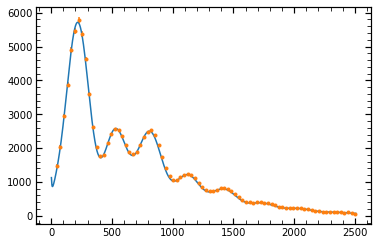

In [3]:
# Copied code from planck_likelihood

def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    
    return (tt[2:])[:len(spec)]


plt.ion()

pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95]) #np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]

errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
resid=spec-model
chisq=np.sum((resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")

#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

The $\chi^2$ value from the test-script parameters is 15267.937968222595, where the standard deviation of $\chi^2$ is $\sqrt{2n} = \sqrt{2(n_d-n_m)}$ for $n_m$ the number of parameters in our model (6) and $n_d$ the number of data points (2507). Therefore, given the standard deviation, $\sqrt{2n} = \sqrt{2(2507-6)} \approx 70.725$, which implies that for a mean of $n = 2501$, a $\chi^2$ $\approx 15268$ is approximately $(15268-2501)/70.725 = 180.5 \sigma$ from the mean. Therefore, this is a poor fit. For parameters equal to [69,0.022,0.12,0.06,2.1e-9,0.95], $\chi^2$ is 3272.2033778089576, which implies a deviation from the mean of $(3272.203377808957-2501)/70.725 \approx 10.90\sigma$.

# Q2) Use Newton's method or LM to find the best-fit parameters, using numerical derivatives. Your code should report your best-fit parameters and their errors in planck_fit_params.txt. Please write your own fitter/numerical-derivative-taker rather than stealing one. Keep track of curvature matrix at the best-fit values for the next problem. What are best-fit parameters with the DM density set to zero - how does this $\chi^2$ compare to the standard value? If you get this to work, print the parameters/errors  in planck_fit_params_nodm.txt.

We will write a LM non-linear least squares method using the double-sided derivative approximation to compute the numerical derivatives w.r.t. each of the model parameters. These derivatives will take the form, 

\begin{equation}
\frac{df}{dx_i} = \frac{f(x_i+\delta) - f(x_i-\delta)}{2\delta}
\end{equation}

for $x_i$ the parameter the derivative is taken with respect to. We will take the $\delta$ values to be approximately one hundredth of the parameter value to ensure our step sizes are neither too large nor too small.

In [6]:
# LM functions

def get_model_derivs(params, deltas, lmax=3000):
    # 6 model parameters
    H0, omegabh2, omegaCh2, tau, A, ns = params
    
    # deltas for derivative
    delta0, delta1, delta2, delta3, delta4, delta5 = deltas
    
    # Model corresponding to params given
    mod = get_spectrum(params)
    
    # Use double sided derivative approximation to compute numerical derivatives given delta
    der_H0 = (get_spectrum([H0+delta0, omegabh2, omegaCh2, tau, A, ns])-get_spectrum([H0-delta0, omegabh2, omegaCh2, tau, A, ns]))/(2*delta0)
    der_omegabh2 = (get_spectrum([H0, omegabh2+delta1, omegaCh2, tau, A, ns])-get_spectrum([H0, omegabh2-delta1, omegaCh2, tau, A, ns]))/(2*delta1)
    der_omegaCh2 = (get_spectrum([H0, omegabh2, omegaCh2+delta2, tau, A, ns])-get_spectrum([H0, omegabh2, omegaCh2-delta2, tau, A, ns]))/(2*delta2)
    der_tau = (get_spectrum([H0, omegabh2, omegaCh2, tau+delta3, A, ns])-get_spectrum([H0, omegabh2, omegaCh2, tau-delta3, A, ns]))/(2*delta3)
    der_A = (get_spectrum([H0, omegabh2, omegaCh2, tau, A+delta4, ns])-get_spectrum([H0, omegabh2, omegaCh2, tau, A-delta4, ns]))/(2*delta4)
    der_ns = (get_spectrum([H0, omegabh2, omegaCh2, tau, A, ns+delta5])-get_spectrum([H0, omegabh2, omegaCh2, tau, A, ns-delta5]))/(2*delta5)    
    
    # Put derivatives into an array to use in LM method
    derivs = np.zeros([len(der_H0), len(params)]) # lmax is number of moments
    derivs[:,0] = der_H0
    derivs[:,1] = der_omegabh2
    derivs[:,2] = der_omegaCh2
    derivs[:,3] = der_tau
    derivs[:,4] = der_A
    derivs[:,5] = der_ns
    
    return mod, derivs

def update_lmbda(lmbda, success):
    """
    Update lambda value for the Levenberg-Marquandt based on the success of the previous step. 
    Outline taken from class code.
    """
    if success == False:
        if lmbda == 0:
            lmbda = 1
        else:
            lmbda = 2*lmbda
    else:
        if lmbda < 0.2:
            lmbda = 0
        else:
            lmbda = lmbda/np.sqrt(2)
    return lmbda

In [9]:
def LM(nsteps, data, p0, errors, deltas, chisq_threshold):
    # need to evaluate chi-sq for first iteration
    params = p0
    model, derivs = get_model_derivs(params, deltas) 
    model, derivs = model, derivs # cut off for data comparison
    res = data-model
    chisq = np.sum((res/errors)**2)
    Ninv = np.diag(1/errors**2) # put errors into matrix form for matrix multiplication
    chisq_accept = [float(chisq)] # all accepted chi-square values
    lmbda = 0
    
    for i in range(nsteps):
        #To solve: (J^T@N^{-1}@J + lmbda*diag(J^T@N^{-1}@J))*dp = J^T@N^{-1}@res ; J=Jacobian, N=diag(1/errs**2)
        rhs = derivs.T@Ninv@res
        lhs = derivs.T@Ninv@derivs + lmbda*np.diag(np.diag(derivs.T@Ninv@derivs))
        lhs_inv = np.linalg.inv(lhs)
        new_cov = lhs_inv # covariance matrix is inverse of LHS
        new_params = params + lhs_inv@rhs # old params + param_update
        new_model, new_derivs = get_model_derivs(new_params, deltas)
        new_model, new_derivs = new_model, new_derivs
        new_res =  data - new_model
        new_chisq = np.sum((new_res/errors)**2)
        delta_chisq = new_chisq - chisq
        print('Step '+repr(i)+': chi-squared change = '+repr(delta_chisq))
        
        if new_chisq <= chisq: # update all variables given successful step
            res = new_res
            chisq = new_chisq
            derivs = new_derivs
            params = new_params
            cov = new_cov
            lmbda = update_lmbda(lmbda, success=True)
            print('Successful step, updating lambda to '+repr(lmbda)+'.')
            chisq_accept.append(float(chisq)) # keep list of accepted chi-square values

            if  (i > 0) and (lmbda == 0) and (np.abs(delta_chisq) < chisq_threshold):
                print('Solution coverged after '+repr(i+1)+' iterations.')
                break
        
        else:
            lmbda = update_lmbda(lmbda, success=False) # update lmbda given unsuccessful steps
            print('Unsuccessful step, updating lambda to '+repr(lmbda)+'.')

    #fobj = open(r"planck_fit_params.txt","w")
    #string = ''
    #params_name = ['H0: ', 'Omegabh2: ', 'OmegaCh2: ', 'tau: ', 'Amp: ', 'ns: ']
    
    #for i in range(len(params)):
    #    string += params_name[i] + str(params[i])+' +/- ' + str(np.sqrt(np.abs(np.diag(cov)))[i]) + '\n'
    #fobj.write(string)
    #fobj.close()
    
    return params, cov, chisq_accept

chisq_threshold = 0.01
p0 = np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95]) # initial guess params from script
deltas = [0.1,1e-4,1e-3,1e-4,1e-11,1e-3]
errs = errs
data = spec
converged_params, converged_cov, chisq_accept = LM(10, data, p0, errs, deltas, chisq_threshold)

Step 0: chi-squared change = -683.2501092834941
Successful step, updating lambda to 0.
Step 1: chi-squared change = -11.215547943730144
Successful step, updating lambda to 0.
Step 2: chi-squared change = -1.5667773768400366
Successful step, updating lambda to 0.
Step 3: chi-squared change = -0.017982266021590476
Successful step, updating lambda to 0.
Step 4: chi-squared change = -0.0006623898748330248
Successful step, updating lambda to 0.
Solution coverged after 5 iterations.


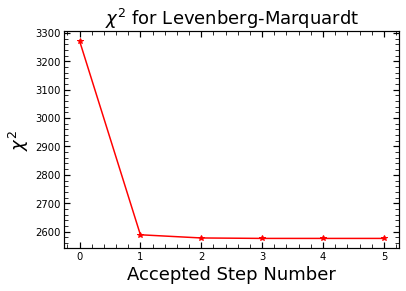

In [10]:
# Now plot Chi-square evolution to verify it has converged or is at least decreasing with steps

plt.plot(chisq_accept, 'r*-')
plt.xlabel('Accepted Step Number', fontsize=18)
plt.ylabel('$\chi^2$', fontsize=18)
plt.title('$\chi^2$ for Levenberg-Marquardt', fontsize=18);
#plt.savefig('chi_square_LM.jpeg')

# Q3) Write an MCMC sampler to get parameter values and uncertainties. Draw trial steps from the curvature matrix from Q2. Save your chain, including the corresponding $\chi^2$ values in planck_chain.txt. Explain why you think your chains have converged. What is your estimate on the mean value of dark energy $\Omega_{\Lambda}$ and its uncertainty (given $\Omega_{b}$+$\Omega_{C}$+$\Omega_{\Lambda}$=1).

In [300]:
def get_step(cov):
    cov_chol = np.linalg.cholesky(cov)
    return cov_chol@np.random.randn(cov_chol.shape[0])

def run_mcmc(data, start_pos, nsteps, cov, scale, tau=False): # scale to get acceptance rate of 25%
    # set up first iteration of mcmc
    nparam=start_pos.size
    params=np.zeros([nsteps, nparam+1])
    params[0,1:] = start_pos
    res=data-get_spectrum(start_pos)
    cur_chisq=np.sum((res/errs)**2)
    params[0,0] = cur_chisq
    cur_pos = start_pos.copy()
    nsteps_accept = 0 # keep track of number of accepted steps
    
    for i in range(1, nsteps):
        
        new_pos = cur_pos + scale*get_step(cov)
        
        if tau:
            new_pos[3] = np.random.normal(loc=0.054, scale=0.0074) # sample tau from Gaussian

        if new_pos[3] < 0: # need tau > 0
            print('Negative tau, skipping step.')
            continue
            
        new_res = data-get_spectrum(new_pos)
        new_chisq=np.sum((new_res/errs)**2)
        
        if i%100 == 0: # progress indicator
            print('Step Number: ', i, ' Acceptance Rate: ', accept_rate)
    
            
        if new_chisq < cur_chisq:
            accept=True
            
        else:
            delt = new_chisq-cur_chisq
            prob = np.exp(-delt/2)
            
            if np.random.rand()<prob:
                accept=True
                
            else:
                accept=False
                
        if accept:
            nsteps_accept += 1
            cur_pos=new_pos
            cur_chisq=new_chisq
            
        params[i,1:]=cur_pos
        params[i,0]=cur_chisq
        accept_rate = (nsteps_accept/i)
        
    return params, accept_rate

p0=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
cov = converged_cov # use covariance matrix from LM
chisq_pars, acceptance_rate = run_mcmc(spec, p0, 5000, cov, scale=0.85)
#np.savetxt('planck_chain.txt', chisq_pars) # save to txt file
print('The acceptance rate of proposed steps is: ', acceptance_rate)

KeyboardInterrupt: 

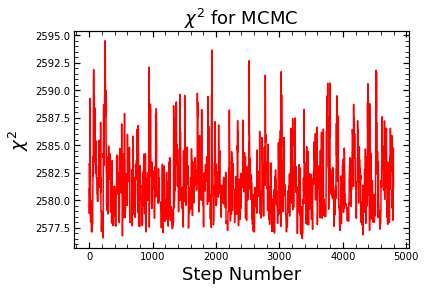

In [13]:
# Now plot Chi-square evolution to verify it has converged or is at least decreasing with steps

chisq_pars = np.loadtxt('planck_chain.txt') # load in chains
plt.plot(chisq_pars[200:,0], 'r-')
plt.xlabel('Step Number', fontsize=18)
plt.ylabel('$\chi^2$', fontsize=18)
plt.title('$\chi^2$ for MCMC', fontsize=18);
#plt.savefig('chi_square_MCMC.jpeg')

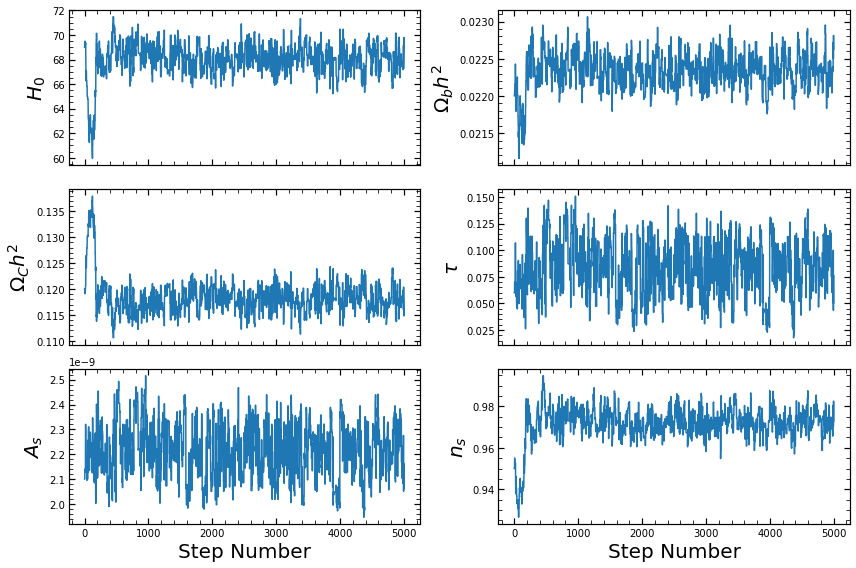

In [14]:
# Plot the corresponding Markov chains, look at parameter space exploration

fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12,8))

axes[0,0].plot(chisq_pars[:,1])
axes[0,1].plot(chisq_pars[:,2])
axes[1,0].plot(chisq_pars[:,3])
axes[1,1].plot(chisq_pars[:,4])
axes[2,0].plot(chisq_pars[:,5])
axes[2,1].plot(chisq_pars[:,6])
axes[0,0].set_ylabel('$H_0$', fontsize=20)
axes[0,1].set_ylabel('$\Omega_b h^2$', fontsize=20)
axes[1,0].set_ylabel('$\Omega_C h^2$', fontsize=20)
axes[1,1].set_ylabel(r'$\tau$', fontsize=20)
axes[2,0].set_ylabel('$A_s$', fontsize=20)
axes[2,1].set_ylabel('$n_s$', fontsize=20)
axes[2,0].set_xlabel('Step Number', fontsize=20)
axes[2,1].set_xlabel('Step Number', fontsize=20)

plt.tight_layout()
plt.tight_layout()
#fig.savefig('param_chains.jpeg')
plt.show()

To verify chain the has converged, look at the $\chi^2$ evolution with time (steps). If $\chi^2$ has stabilized by the end of the chain, remaining relatively constant over a significant number of steps, we can say with decent confidence that the chain has converged. We can also look at the fourier transform of the chains and plot the result, which will display the power spectrum of the Markov chain. If the power spectrum  for a given parameter flattens off in the left half of the spectrum, this is indicative of convergence. Further, looking at the corner plots of the parameters can provide some indication as to whether our MCMC converged to a specific range of parameter values.

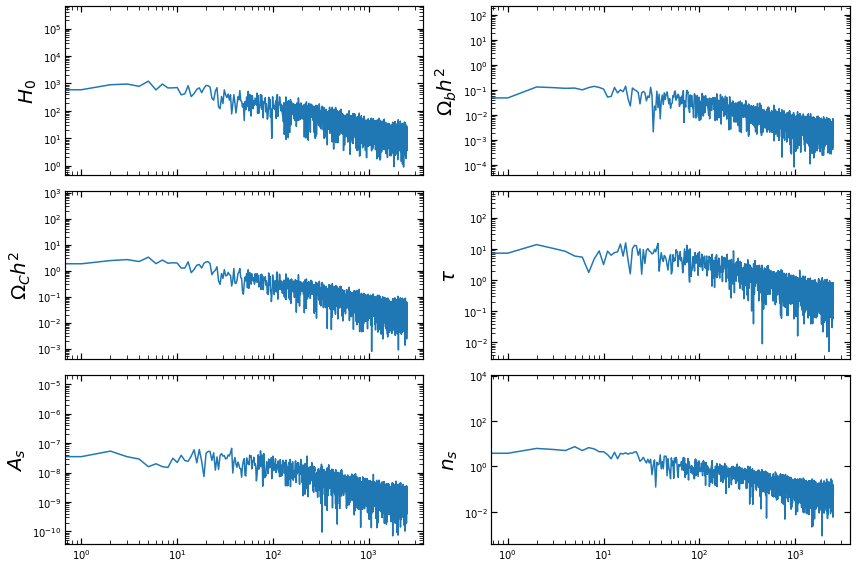

In [15]:
# Plot power spectra for each parameter
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12,8))

axes[0,0].loglog(np.abs(np.fft.rfft(chisq_pars[:,1])))
axes[0,1].loglog(np.abs(np.fft.rfft(chisq_pars[:,2])))
axes[1,0].loglog(np.abs(np.fft.rfft(chisq_pars[:,3])))
axes[1,1].loglog(np.abs(np.fft.rfft(chisq_pars[:,4])))
axes[2,0].loglog(np.abs(np.fft.rfft(chisq_pars[:,5])))
axes[2,1].loglog(np.abs(np.fft.rfft(chisq_pars[:,6])))
axes[0,0].set_ylabel('$H_0$', fontsize=20)
axes[0,1].set_ylabel('$\Omega_b h^2$', fontsize=20)
axes[1,0].set_ylabel('$\Omega_C h^2$', fontsize=20)
axes[1,1].set_ylabel(r'$\tau$', fontsize=20)
axes[2,0].set_ylabel('$A_s$', fontsize=20)
axes[2,1].set_ylabel('$n_s$', fontsize=20)

plt.tight_layout()
plt.tight_layout()
#fig.savefig('param_powerspectra_diffsize.jpeg')
plt.show()

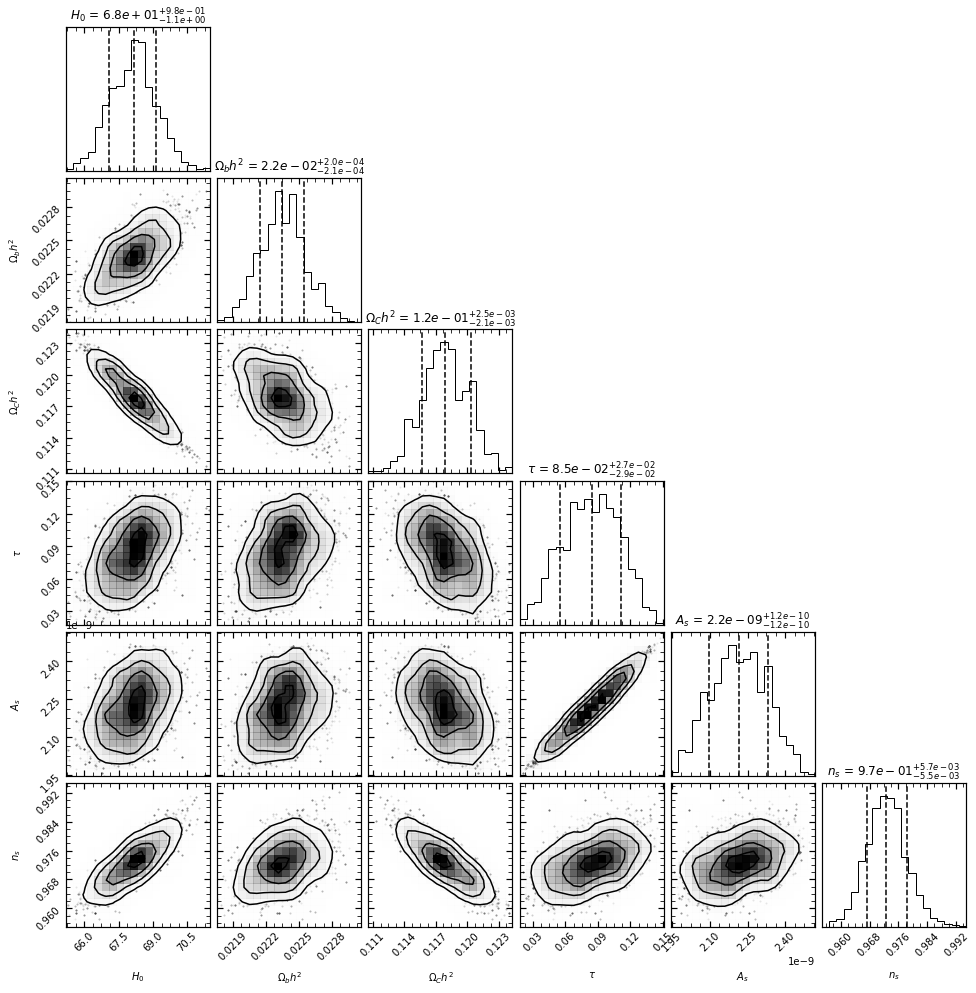

MCMC Parameter Chain Mean and Standard Deviations
$H_0$ :  68.14079520673587  +/-  1.009777085221404
$\Omega_b h^2$ :  0.02235487961316251  +/-  0.00020549792441025767
$\Omega_C h^2$ :  0.11790599322240808  +/-  0.002265785528687319
$\tau$ :  0.08394187563449317  +/-  0.025798756168032417
$A_s$ :  2.216004694881778e-09  +/-  1.0847977552979233e-10
$n_s$ :  0.9727317636379677  +/-  0.005666796114832301


In [18]:
import corner

# Plot posterior distributions of the parameters and their covariances with other parameters in the model

pars = np.array(chisq_pars[200:,1:])
corner.corner(pars,labels=["$H_0$","$\Omega_b h^2$", '$\Omega_C h^2$', r'$\tau$', '$A_s$','$n_s$'],
              show_titles=True,quantiles=[0.16, 0.5, 0.84], title_fmt='.1e', smooth=True)
#plt.savefig('cornerplot_MCMC_1sigfig_burnin.jpeg')
plt.show()

# Now compute the mean and standard deviation of the chains, assuming Gaussianity

labels=["$H_0$","$\Omega_b h^2$", '$\Omega_C h^2$', r'$\tau$', '$A_s$','$n_s$'] 
print('MCMC Parameter Chain Mean and Standard Deviations')
for i in range(1,7):
    print(labels[i-1], ': ', np.mean(chisq_pars[200:,i]), ' +/- ', np.std(chisq_pars[200:,i]))

Therefore, given we have plotted the power spectra of the chains and observe a slight flattening of the power on the left side of the plot for each parameter, we can consider the chains to have converged. It is likely that with more iterations (i.e. $10^4$) we would observe a more extreme flattening, and a more noticeable 'knee' in the power spectrum, however due to computational time limitations this is sufficient to tentatively say that the chains have converged.

Now, to estimate the mean value of the dark energy, we can consider the formula, 

\begin{equation}
\Omega_{b}+\Omega_{C}+\Omega_{\Lambda}=1 \implies \Omega_{\Lambda}=1 - \Omega_{b} - \Omega_{C}
\end{equation}

where we have solved for $\Omega_{b}h^2$ and $\Omega_{C}h^2$, for $h=H_0/100$, where we have also estimated $H_0$. Therefore, we can estimate $\Omega_{\Lambda}$ as, 


\begin{equation}
\Omega_{\Lambda}= 1 - \frac{100^2 \Omega_{b} h^2}{H_0^2} - \frac{100^2 \Omega_{C} h^2}{H_0^2} \approx 0.697920
\end{equation}

and its uncertainty as,

\begin{equation}
\delta \Omega_{\Lambda} = \sqrt{\left(\frac{d\Omega_{\Lambda}}{d\Omega_{b}h^2} \delta \Omega_{b}h^2\right)^2 + \left(\frac{d\Omega_{\Lambda}}{d\Omega_{C}h^2} \delta \Omega_{C}h^2\right)^2 + \left(\frac{d\Omega_{\Lambda}}{dH_0}\delta H_0\right)^2}.
\end{equation}

Evaluating these derivatives analytically and plugging them back into the above formula for $\delta \Omega_{\Lambda}$, we get, 

\begin{equation}
\delta \Omega_{\Lambda} = \sqrt{\left(-\frac{100^2(0.00020550)}{68.1410^2}\right)^2 + \left(-\frac{100^2(0.002266)}{68.1410^2}\right)^2 + \left(\left(\frac{2(100^2)(0.02235488)}{68.1410^3}+\frac{2(100^2)(0.1179060)}{68.1410^3}\right)1.0098\right)^2} \approx 0.010207
\end{equation}



# Q4) Polarization data give a much better constraint on reionization, with $\tau = 0.0540 \pm 0.0074$. Run a new chain where you include this constraint (saved to planck_chain_tau_prior.txt) and compare those results to what you get from importance sampling you chain from Problem 3. Re-estimate the parameter covariance matrix (via importance sampling) before running the new chain.

First, we can compute the results from importance sampling our chain from Q3, which just implies we need to recalculate using the weighted mean/standard error for Gaussian weights on $\tau$.

In [61]:
# gaussian prior on tau, passing tau chain to this to get gaussian weights

def tau_gauss(tau):
    sigma = 0.0074
    mean = 0.0540
    return (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(tau-mean)**2 / (2*sigma**2))

tau_chain = chisq_pars[:,4]
tau_prior_weights = tau_gauss(tau_chain) # gaussian weights w.r.t. tau

In [63]:
# Define function to compute weighted mean and standard error in weighted mean

def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

H0,ombh2,omch2,As,ns=chisq_pars[200:,1], chisq_pars[200:,2], chisq_pars[200:,3], chisq_pars[200:,5], chisq_pars[200:,6]

# Now calculate, weighted mean and standard deviation for each parameter

H0_w, H0_std = weighted_avg_and_std(H0,tau_prior_weights[200:])
ombh2_w, ombh2_std = weighted_avg_and_std(ombh2,tau_prior_weights[200:])
omch2_w, omch2_std = weighted_avg_and_std(omch2,tau_prior_weights[200:])
tau_w, tau_std = weighted_avg_and_std(tau_chain[200:],tau_prior_weights[200:])
As_w, As_std = weighted_avg_and_std(As,tau_prior_weights[200:])
ns_w, ns_std = weighted_avg_and_std(ns,tau_prior_weights[200:])

print('Weighted $H_0$: ', H0_w, '+/-', H0_std)
print(r'Weighted $\Omega_{b}h^2$: ', ombh2_w, '+/-', ombh2_std)
print(r'Weighted $\Omega_{c}h^2$: ', omch2_w, '+/-', omch2_std)
print(r'Weighted $\tau$: ', tau_w, '+/-', tau_std)
print(r'Weighted $A_s$: ', As_w, '+/-', As_std)
print(r'Weighted $n_s$: ', ns_w, '+/-', ns_std)

Weighted $H_0$:  67.6578185358697 +/- 0.9097656962882535
Weighted $\Omega_{b}h^2$:  0.022279900205468387 +/- 0.00017863972675105733
Weighted $\Omega_{c}h^2$:  0.11889116949649113 +/- 0.0021360595269455896
Weighted $\tau$:  0.05515313947357065 +/- 0.007436617921098509
Weighted $A_s$:  2.0961526047753257e-09 +/- 3.207178782148364e-11
Weighted $n_s$:  0.9699137595457195 +/- 0.005113032680747711


In [43]:
# Now importance sample the chain from Q3, using the weighted means 

tau_normed_weights = tau_prior_weights[200:]/np.sum(tau_prior_weights[200:])

w_param_chain = 0*chisq_pars[200:,1:] # now make a chain with the weighted mean in each 
w_param_chain[:,0] = H0_w
w_param_chain[:,1] = ombh2_w
w_param_chain[:,2] = omch2_w
w_param_chain[:,3] = tau_w
w_param_chain[:,4] = As_w
w_param_chain[:,5] = ns_w
w_param_chain = w_param_chain.T
chain_params = chisq_pars[200:,1:].T

# New importance sampling covariance matrix will be:
# Normed_weights*(chains - weighted_mean_params)@(chains - weighted_mean_params)^T

weighted_cov = tau_normed_weights*(chain_params - w_param_chain)@(chain_params - w_param_chain).T

In [49]:
# We need to now run our chain with the new covariance matrix and Gaussian sampling of tau

p0=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
q4_cov = np.cov(chisq_pars[200:,1:].T, aweights=tau_prior_weights[200:]) # removed first 200 as burnin
q4_chisq_pars, q4_acceptance_rate = run_mcmc(spec, p0, 4000, q4_cov, scale=0.1, tau=True)
print('The acceptance rate of proposed steps is: ', q4_acceptance_rate)

Step Number:  500  Acceptance Rate:  0.09418837675350701
Step Number:  1000  Acceptance Rate:  0.0990990990990991
Step Number:  1500  Acceptance Rate:  0.09939959973315543
Step Number:  2000  Acceptance Rate:  0.09304652326163082
Step Number:  2500  Acceptance Rate:  0.10004001600640255
Step Number:  3000  Acceptance Rate:  0.09836612204068022
Step Number:  3500  Acceptance Rate:  0.1034581308945413
The acceptance rate of proposed steps is:  0.10427606901725431


In [50]:
#np.savetxt('planck_chain_tauprior.txt', q4_chisq_pars) # save to txt file

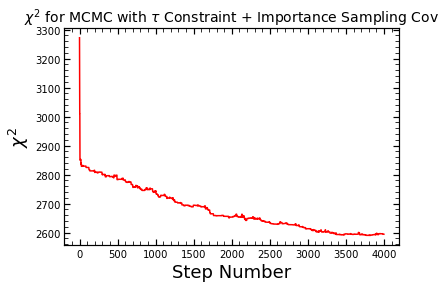

In [68]:
# Now plot Chi-square evolution to verify it has converged or is at least decreasing with steps

plt.plot(q4_chisq_pars[:,0], 'r-')
plt.xlabel('Step Number', fontsize=18)
plt.ylabel('$\chi^2$', fontsize=18)
plt.title(r'$\chi^2$ for MCMC with $\tau$ Constraint + Importance Sampling Cov', fontsize=14);
plt.savefig('chi_square_MCMC_Q4.jpeg')

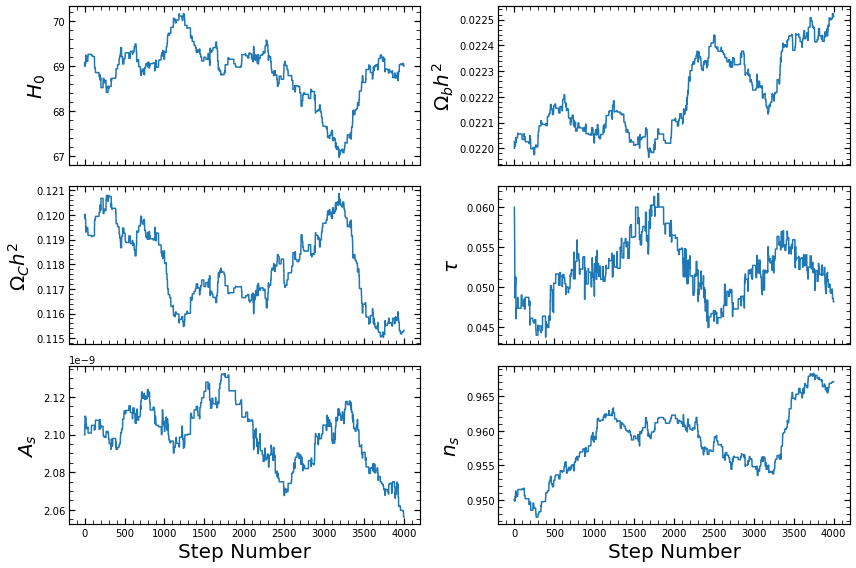

In [52]:
# Plot the corresponding Markov chains, look at parameter space exploration

fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12,8))

axes[0,0].plot(q4_chisq_pars[:,1])
axes[0,1].plot(q4_chisq_pars[:,2])
axes[1,0].plot(q4_chisq_pars[:,3])
axes[1,1].plot(q4_chisq_pars[:,4])
axes[2,0].plot(q4_chisq_pars[:,5])
axes[2,1].plot(q4_chisq_pars[:,6])
axes[0,0].set_ylabel('$H_0$', fontsize=20)
axes[0,1].set_ylabel('$\Omega_b h^2$', fontsize=20)
axes[1,0].set_ylabel('$\Omega_C h^2$', fontsize=20)
axes[1,1].set_ylabel(r'$\tau$', fontsize=20)
axes[2,0].set_ylabel('$A_s$', fontsize=20)
axes[2,1].set_ylabel('$n_s$', fontsize=20)
axes[2,0].set_xlabel('Step Number', fontsize=20)
axes[2,1].set_xlabel('Step Number', fontsize=20)

plt.tight_layout()
plt.tight_layout()
fig.savefig('param_chains_q4_new.jpeg')
plt.show()

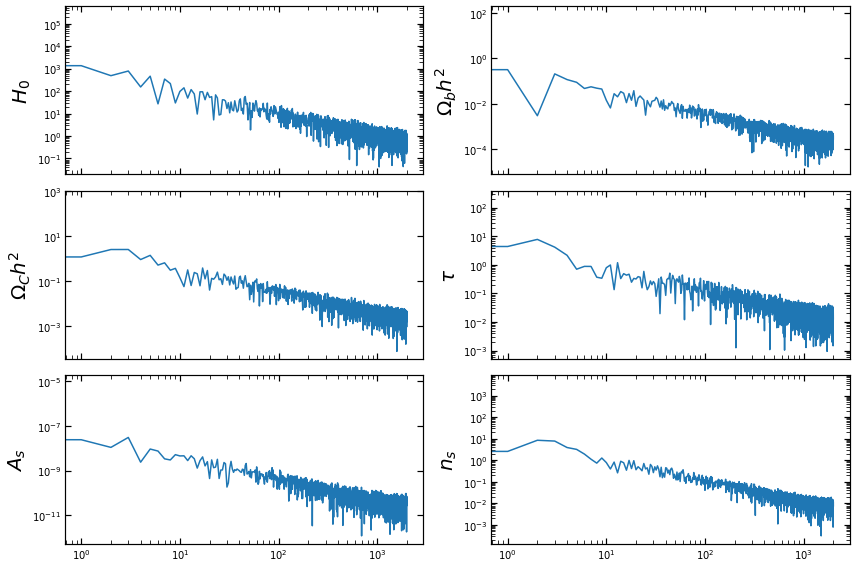

In [53]:
# Plot power spectra for each parameter
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12,8))

axes[0,0].loglog(np.abs(np.fft.rfft(q4_chisq_pars[:,1])))
axes[0,1].loglog(np.abs(np.fft.rfft(q4_chisq_pars[:,2])))
axes[1,0].loglog(np.abs(np.fft.rfft(q4_chisq_pars[:,3])))
axes[1,1].loglog(np.abs(np.fft.rfft(q4_chisq_pars[:,4])))
axes[2,0].loglog(np.abs(np.fft.rfft(q4_chisq_pars[:,5])))
axes[2,1].loglog(np.abs(np.fft.rfft(q4_chisq_pars[:,6])))
axes[0,0].set_ylabel('$H_0$', fontsize=20)
axes[0,1].set_ylabel('$\Omega_b h^2$', fontsize=20)
axes[1,0].set_ylabel('$\Omega_C h^2$', fontsize=20)
axes[1,1].set_ylabel(r'$\tau$', fontsize=20)
axes[2,0].set_ylabel('$A_s$', fontsize=20)
axes[2,1].set_ylabel('$n_s$', fontsize=20)

plt.tight_layout()
plt.tight_layout()
fig.savefig('param_powerspectra_q4_new.jpeg')
plt.show()

In [54]:
labels=["$H_0$","$\Omega_b h^2$", '$\Omega_C h^2$', r'$\tau$', '$A_s$','$n_s$'] 
print('MCMC Parameter Chain Mean and Standard Deviations')
for i in range(1,7):
    print(labels[i-1], ': ', np.mean(q4_chisq_pars[200:,i]), ' +/- ', np.std(q4_chisq_pars[200:,i]))

MCMC Parameter Chain Mean and Standard Deviations
$H_0$ :  68.84518145856889  +/-  0.6566882507920437
$\Omega_b h^2$ :  0.022212619129479326  +/-  0.00015277898695151043
$\Omega_C h^2$ :  0.11779459154370014  +/-  0.0015463959057510832
$\tau$ :  0.05218120101983619  +/-  0.0037771306031518506
$A_s$ :  2.0994159702806663e-09  +/-  1.6533386084777263e-11
$n_s$ :  0.9588460455432062  +/-  0.004597532011922516
